In [2]:
import pandas as pd
import numpy as np

In [4]:
loan_data_backup = pd.read_csv('/home/karan/Documents/Credit Risk Modelling/datasets/loan_data_2007_2014.csv')

In [5]:
loan_data = loan_data_backup.copy()
pd.options.display.max_columns=None

In [6]:
#formatting years
loan_data['emp_length_int'] = loan_data['emp_length'].str.replace('\+ years', '')
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace('< 1 year', str(0))
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace('n/a',  str(0))
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace(' years', '')
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace(' year', '')
loan_data['emp_length_int'] = pd.to_numeric(loan_data['emp_length_int'])

In [7]:
#convert date data from string to datetime
loan_data['earliest_cr_line_date'] = pd.to_datetime(loan_data['earliest_cr_line'], format = '%b-%y')

In [8]:
#days from earliest loan
pd.to_datetime('2017-12-01') - loan_data['earliest_cr_line_date']

0        12022 days
1         6819 days
2         5874 days
3         7974 days
4         8005 days
            ...    
466280    5358 days
466281    7488 days
466282    5844 days
466283    5417 days
466284    6513 days
Name: earliest_cr_line_date, Length: 466285, dtype: timedelta64[ns]

In [10]:
loan_data['mths_since_earliest_cr_line'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - loan_data['earliest_cr_line_date']) / np.timedelta64(1, 'M')))

In [11]:
loan_data['mths_since_earliest_cr_line'][loan_data['mths_since_earliest_cr_line'] < 0] = loan_data['mths_since_earliest_cr_line'].max()

/home/karan/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
min(loan_data['mths_since_earliest_cr_line'])

73.0

In [13]:
loan_data['term_int'] = pd.to_numeric(loan_data['term'].str.replace(' months', ''))
loan_data['issue_d_date'] = pd.to_datetime(loan_data['issue_d'], format = '%b-%y')
loan_data['mths_since_issue_d'] = round(pd.to_numeric((pd.to_datetime('2017-12-01') - loan_data['issue_d_date']) / np.timedelta64(1, 'M')))
loan_data['mths_since_issue_d'].describe()

count    466285.000000
mean         51.255187
std          14.340154
min          36.000000
25%          41.000000
50%          47.000000
75%          57.000000
max         126.000000
Name: mths_since_issue_d, dtype: float64

In [14]:
pd.get_dummies(loan_data['grade'], prefix = 'grade', prefix_sep = ':')

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G
0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0
5,1,0,0,0,0,0,0
6,0,0,1,0,0,0,0
7,0,0,0,0,1,0,0
8,0,0,0,0,0,1,0
9,0,1,0,0,0,0,0


In [15]:
loan_data_dummies = [pd.get_dummies(loan_data['grade'], prefix = 'grade', prefix_sep = ':'),
                     pd.get_dummies(loan_data['sub_grade'], prefix = 'sub_grade', prefix_sep = ':'),
                     pd.get_dummies(loan_data['home_ownership'], prefix = 'home_ownership', prefix_sep = ':'),
                     pd.get_dummies(loan_data['verification_status'], prefix = 'verification_status', prefix_sep = ':'),
                     pd.get_dummies(loan_data['loan_status'], prefix = 'loan_status', prefix_sep = ':'),
                     pd.get_dummies(loan_data['purpose'], prefix = 'purpose', prefix_sep = ':'),
                     pd.get_dummies(loan_data['addr_state'], prefix = 'addr_state', prefix_sep = ':'),
                     pd.get_dummies(loan_data['initial_list_status'], prefix = 'initial_list_status', prefix_sep = ':')]

In [16]:
loan_data_dummies = pd.concat(loan_data_dummies, axis = 1)

In [17]:
loan_data = pd.concat([loan_data, loan_data_dummies], axis = 1)

In [18]:
loan_data['annual_inc'].fillna(loan_data['annual_inc'].mean(), inplace=True)
loan_data['mths_since_earliest_cr_line'].fillna(0, inplace=True)
loan_data['acc_now_delinq'].fillna(0, inplace=True)
loan_data['total_acc'].fillna(0, inplace=True)
loan_data['pub_rec'].fillna(0, inplace=True)
loan_data['open_acc'].fillna(0, inplace=True)
loan_data['inq_last_6mths'].fillna(0, inplace=True)
loan_data['delinq_2yrs'].fillna(0, inplace=True)
loan_data['emp_length_int'].fillna(0, inplace=True)

In [ ]:
loan_data['loan_status'].value_counts() / loan_data['loan_status'].count()

In [19]:
loan_data['good_bad'] = np.where(loan_data['loan_status'].isin(['Charged Off', 'Default',
                                                               'Does not meet the credit policy. Status:Charged Off',
                                                               'Late (31-120 days)']), 0, 1)

In [20]:
loan_data['good_bad']

0         1
1         0
2         1
3         1
4         1
         ..
466280    1
466281    0
466282    1
466283    1
466284    1
Name: good_bad, Length: 466285, dtype: int64

In [46]:
from sklearn.model_selection import train_test_split
loan_data_inputs_train, loan_data_inputs_test, loan_data_targets_train, loan_data_targets_test = train_test_split(loan_data.drop('good_bad', axis = 1), loan_data['good_bad'], test_size = 0.2, random_state = 42)

In [47]:
df_inputs_prepr = loan_data_inputs_train
df_targets_prepr = loan_data_targets_train
df1 = pd.concat([df_inputs_prepr['grade'], df_targets_prepr], axis = 1)

In [48]:
df1.groupby(df1.columns.values[0], as_index = False)[df1.columns.values[1]].count()


,grade,good_bad
0,A,59759
1,B,109730
2,C,100245
3,D,61498
4,E,28612
5,F,10530
6,G,2654


In [49]:
df1.groupby(df1.columns.values[0], as_index = False)[df1.columns.values[1]].mean()
#calculating proportion of good borrowers.sum all ones and divide by total.

,grade,good_bad
0,A,0.961044
1,B,0.921015
2,C,0.885770
3,D,0.846304
4,E,0.805257
5,F,0.754416
6,G,0.727958


In [50]:
df1 = pd.concat([df1.groupby(df1.columns.values[0], as_index = False)[df1.columns.values[1]].count(),
                df1.groupby(df1.columns.values[0], as_index = False)[df1.columns.values[1]].mean()], axis = 1)

In [51]:
df1 = df1.iloc[:, [0, 1, 3]]
df1.columns

Index(['grade', 'good_bad', 'good_bad'], dtype='object')

In [52]:
df1.columns = [df1.columns.values[0], 'n_obs', 'prop_good']


In [53]:
df1['prop_n_obs'] = df1['n_obs'] / df1['n_obs'].sum()
df1['n_good'] = df1['prop_good'] * df1['n_obs']
#number of good loans
df1['n_bad'] = (1 - df1['prop_good']) * df1['n_obs']
df1

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad
0,A,59759,0.961044,0.160200,57431.0,2328.0
1,B,109730,0.921015,0.294160,101063.0,8667.0
2,C,100245,0.885770,0.268733,88794.0,11451.0
3,D,61498,0.846304,0.164862,52046.0,9452.0
4,E,28612,0.805257,0.076702,23040.0,5572.0
5,F,10530,0.754416,0.028228,7944.0,2586.0
6,G,2654,0.727958,0.007115,1932.0,722.0


In [54]:
df1['prop_n_good'] = df1['n_good'] / df1['n_good'].sum()
#calculating proportion of good loans
df1['prop_n_bad'] = df1['n_bad'] / df1['n_bad'].sum()

In [55]:
df1['WoE'] = np.log(df1['prop_n_good'] / df1['prop_n_bad'])
df1 = df1.sort_values(['WoE'])
df1 = df1.reset_index(drop = True)
df1
#WoE is log(%good/%bad)

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE
0,G,2654,0.727958,0.007115,1932.0,722.0,0.005815,0.017706,-1.113459
1,F,10530,0.754416,0.028228,7944.0,2586.0,0.023910,0.063417,-0.975440
2,E,28612,0.805257,0.076702,23040.0,5572.0,0.069345,0.136642,-0.678267
3,D,61498,0.846304,0.164862,52046.0,9452.0,0.156647,0.231792,-0.391843
4,C,100245,0.885770,0.268733,88794.0,11451.0,0.267251,0.280813,-0.049503
5,B,109730,0.921015,0.294160,101063.0,8667.0,0.304178,0.212541,0.358476
6,A,59759,0.961044,0.160200,57431.0,2328.0,0.172855,0.057090,1.107830


In [58]:
df1['diff_prop_good'] = df1['prop_good'].diff().abs()
df1['diff_WoE'] = df1['WoE'].diff().abs()
df1

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV,diff_prop_good,diff_WoE
0,G,2654,0.727958,0.007115,1932.0,722.0,0.005815,0.017706,-1.113459,0.288636,NaN,NaN
1,F,10530,0.754416,0.028228,7944.0,2586.0,0.023910,0.063417,-0.975440,0.288636,0.026458,0.138019
2,E,28612,0.805257,0.076702,23040.0,5572.0,0.069345,0.136642,-0.678267,0.288636,0.050841,0.297173
3,D,61498,0.846304,0.164862,52046.0,9452.0,0.156647,0.231792,-0.391843,0.288636,0.041047,0.286424
4,C,100245,0.885770,0.268733,88794.0,11451.0,0.267251,0.280813,-0.049503,0.288636,0.039466,0.342340
5,B,109730,0.921015,0.294160,101063.0,8667.0,0.304178,0.212541,0.358476,0.288636,0.035245,0.407979
6,A,59759,0.961044,0.160200,57431.0,2328.0,0.172855,0.057090,1.107830,0.288636,0.040028,0.749353


In [59]:
df1['IV'] = (df1['prop_n_good'] - df1['prop_n_bad']) * df1['WoE']
df1['IV'] = df1['IV'].sum()
df1

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,IV,diff_prop_good,diff_WoE
0,G,2654,0.727958,0.007115,1932.0,722.0,0.005815,0.017706,-1.113459,0.288636,NaN,NaN
1,F,10530,0.754416,0.028228,7944.0,2586.0,0.023910,0.063417,-0.975440,0.288636,0.026458,0.138019
2,E,28612,0.805257,0.076702,23040.0,5572.0,0.069345,0.136642,-0.678267,0.288636,0.050841,0.297173
3,D,61498,0.846304,0.164862,52046.0,9452.0,0.156647,0.231792,-0.391843,0.288636,0.041047,0.286424
4,C,100245,0.885770,0.268733,88794.0,11451.0,0.267251,0.280813,-0.049503,0.288636,0.039466,0.342340
5,B,109730,0.921015,0.294160,101063.0,8667.0,0.304178,0.212541,0.358476,0.288636,0.035245,0.407979
6,A,59759,0.961044,0.160200,57431.0,2328.0,0.172855,0.057090,1.107830,0.288636,0.040028,0.749353


In [60]:
# WoE function for discrete unordered variables
def woe_discrete(df, discrete_variabe_name, good_bad_variable_df):
    df = pd.concat([df[discrete_variabe_name], good_bad_variable_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df
# Here we combine all of the operations above in a function.
# The function takes 3 arguments: a dataframe, a string, and a dataframe. The function returns a dataframe as a result.

In [64]:
df_temp = woe_discrete(df_inputs_prepr, 'grade', df_targets_prepr)
df_temp

,grade,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,G,2654,0.727958,0.007115,1932.0,722.0,0.005815,0.017706,-1.113459,NaN,NaN,0.288636
1,F,10530,0.754416,0.028228,7944.0,2586.0,0.023910,0.063417,-0.975440,0.026458,0.138019,0.288636
2,E,28612,0.805257,0.076702,23040.0,5572.0,0.069345,0.136642,-0.678267,0.050841,0.297173,0.288636
3,D,61498,0.846304,0.164862,52046.0,9452.0,0.156647,0.231792,-0.391843,0.041047,0.286424,0.288636
4,C,100245,0.885770,0.268733,88794.0,11451.0,0.267251,0.280813,-0.049503,0.039466,0.342340,0.288636
5,B,109730,0.921015,0.294160,101063.0,8667.0,0.304178,0.212541,0.358476,0.035245,0.407979,0.288636
6,A,59759,0.961044,0.160200,57431.0,2328.0,0.172855,0.057090,1.107830,0.040028,0.749353,0.288636


In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [62]:
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[: , 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize = (18, 6))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)

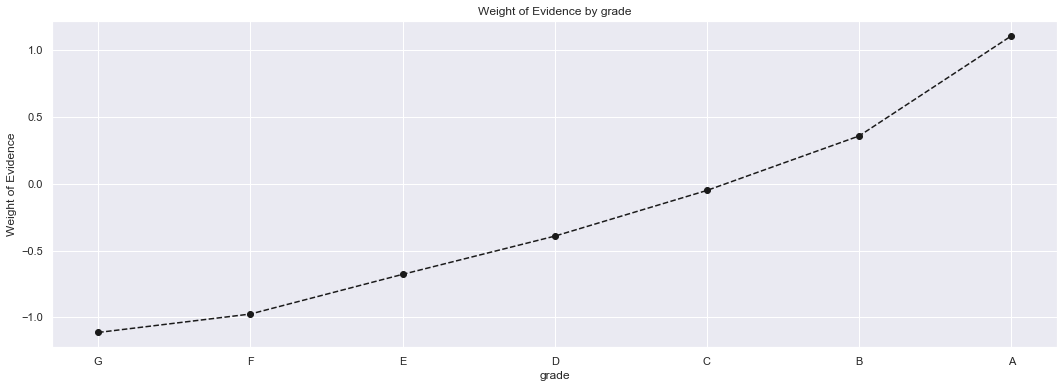

In [65]:
plot_by_woe(df_temp)

In [66]:
df_inputs_prepr['home_ownership:RENT_OTHER_NONE_ANY'] = sum([df_inputs_prepr['home_ownership:RENT'], df_inputs_prepr['home_ownership:OTHER'],
                                                            df_inputs_prepr['home_ownership:NONE'], df_inputs_prepr['home_ownership:ANY']])

In [67]:
df_inputs_prepr['addr_state'].unique()
df_temp = woe_discrete(df_inputs_prepr, 'addr_state', df_targets_prepr)
df_temp

/home/karan/.local/lib/python3.6/site-packages/pandas/core/algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,addr_state,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,NE,13,0.461538,0.000035,6.0,7.0,0.000018,0.000172,-2.251896,NaN,NaN,inf
1,IA,13,0.769231,0.000035,10.0,3.0,0.000030,0.000074,-0.893772,0.307692,1.358123,inf
2,NV,5221,0.864585,0.013996,4514.0,707.0,0.013586,0.017338,-0.243837,0.095355,0.649935,inf
3,FL,25211,0.875808,0.067585,22080.0,3131.0,0.066456,0.076782,-0.144425,0.011223,0.099411,inf
4,HI,2001,0.877061,0.005364,1755.0,246.0,0.005282,0.006033,-0.132852,0.001253,0.011573,inf
5,AL,4671,0.877328,0.012522,4098.0,573.0,0.012334,0.014052,-0.130376,0.000267,0.002476,inf
6,NM,2075,0.883373,0.005563,1833.0,242.0,0.005517,0.005935,-0.072973,0.006045,0.057403,inf
7,VA,11366,0.883864,0.030470,10046.0,1320.0,0.030236,0.032370,-0.068202,0.000491,0.004771,inf
8,NY,32211,0.883984,0.086350,28474.0,3737.0,0.085701,0.091643,-0.067037,0.000120,0.001165,inf
9,OK,3284,0.884287,0.008804,2904.0,380.0,0.008740,0.009319,-0.064072,0.000304,0.002965,inf


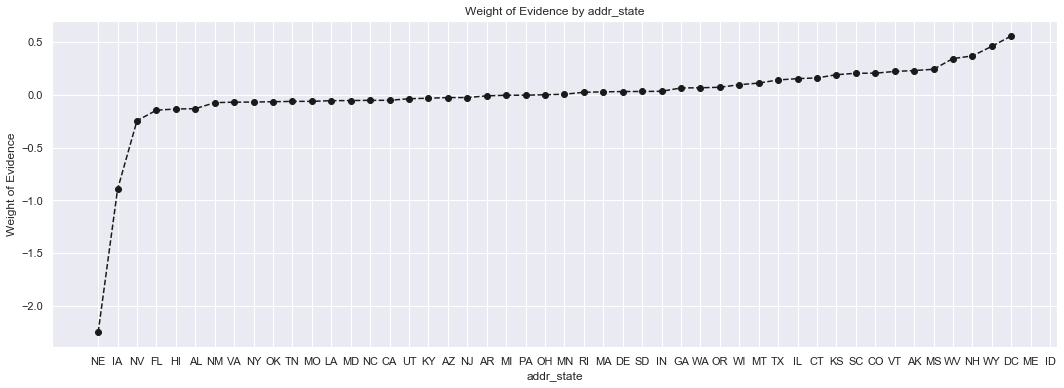

In [68]:
plot_by_woe(df_temp)


In [69]:
#to handle if ND data comes up
if ['addr_state:ND'] in df_inputs_prepr.columns.values:
    pass
else:
    df_inputs_prepr['addr_state:ND'] = 0

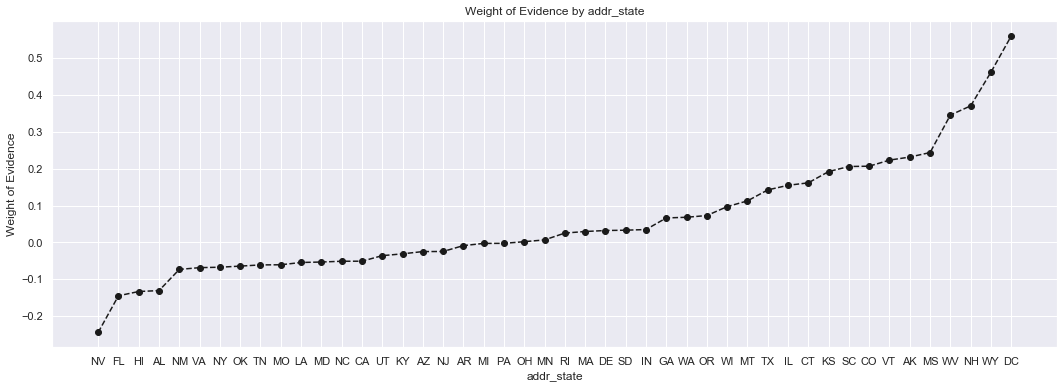

In [70]:
plot_by_woe(df_temp.iloc[2: -2, : ])
#since last two and first two rows are skewing data plot this is to better visualize the middle portion.

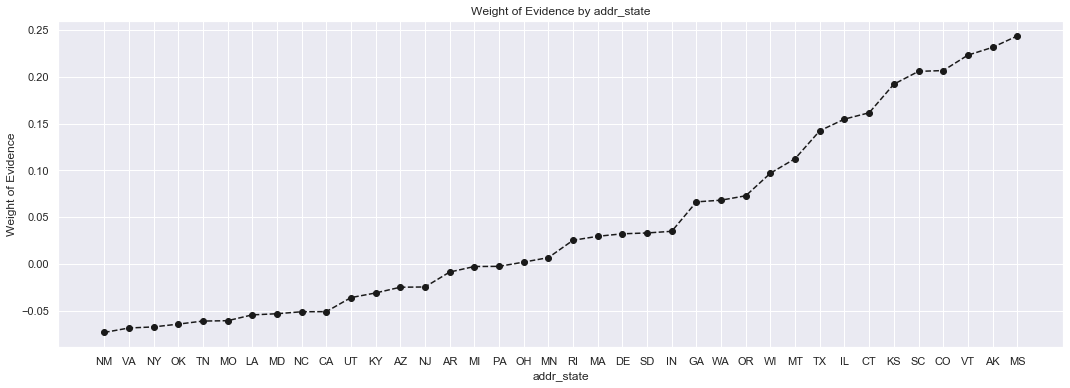

In [71]:
plot_by_woe(df_temp.iloc[6: -6, : ])
#visualizing the middle flat-ish portion clearly by removing the extreme ends

In [72]:
# We create the following categories(on the basis of WoE):
# 'ND' 'NE' 'IA' NV' 'FL' 'HI' 'AL' : since these are the lease WoE states. ND is 0, so max risk. NE,IA have very less observatios so they are clubbed to other states.
# 'NM' 'VA' : different from above category. similar to NY, but NY has too many observations so it is in a different group.
# 'NY'
# 'OK' 'TN' 'MO' 'LA' 'MD' 'NC' : Same reason as NY, but with CA
# 'CA'
# 'UT' 'KY' 'AZ' 'NJ' : similar WoE
# 'AR' 'MI' 'PA' 'OH' 'MN'
# 'RI' 'MA' 'DE' 'SD' 'IN'
# 'GA' 'WA' 'OR'
# 'WI' 'MT'
# 'TX'
# 'IL' 'CT'
# 'KS' 'SC' 'CO' 'VT' 'AK' 'MS'
# 'WV' 'NH' 'WY' 'DC' 'ME' 'ID'

# 'IA_NV_HI_ID_AL_FL' will be the reference category.

df_inputs_prepr['addr_state:ND_NE_IA_NV_FL_HI_AL'] = sum([df_inputs_prepr['addr_state:ND'], df_inputs_prepr['addr_state:NE'],
                                              df_inputs_prepr['addr_state:IA'], df_inputs_prepr['addr_state:NV'],
                                              df_inputs_prepr['addr_state:FL'], df_inputs_prepr['addr_state:HI'],
                                                          df_inputs_prepr['addr_state:AL']])

df_inputs_prepr['addr_state:NM_VA'] = sum([df_inputs_prepr['addr_state:NM'], df_inputs_prepr['addr_state:VA']])

df_inputs_prepr['addr_state:OK_TN_MO_LA_MD_NC'] = sum([df_inputs_prepr['addr_state:OK'], df_inputs_prepr['addr_state:TN'],
                                              df_inputs_prepr['addr_state:MO'], df_inputs_prepr['addr_state:LA'],
                                              df_inputs_prepr['addr_state:MD'], df_inputs_prepr['addr_state:NC']])

df_inputs_prepr['addr_state:UT_KY_AZ_NJ'] = sum([df_inputs_prepr['addr_state:UT'], df_inputs_prepr['addr_state:KY'],
                                              df_inputs_prepr['addr_state:AZ'], df_inputs_prepr['addr_state:NJ']])

df_inputs_prepr['addr_state:AR_MI_PA_OH_MN'] = sum([df_inputs_prepr['addr_state:AR'], df_inputs_prepr['addr_state:MI'],
                                              df_inputs_prepr['addr_state:PA'], df_inputs_prepr['addr_state:OH'],
                                              df_inputs_prepr['addr_state:MN']])

df_inputs_prepr['addr_state:RI_MA_DE_SD_IN'] = sum([df_inputs_prepr['addr_state:RI'], df_inputs_prepr['addr_state:MA'],
                                              df_inputs_prepr['addr_state:DE'], df_inputs_prepr['addr_state:SD'],
                                              df_inputs_prepr['addr_state:IN']])

df_inputs_prepr['addr_state:GA_WA_OR'] = sum([df_inputs_prepr['addr_state:GA'], df_inputs_prepr['addr_state:WA'],
                                              df_inputs_prepr['addr_state:OR']])

df_inputs_prepr['addr_state:WI_MT'] = sum([df_inputs_prepr['addr_state:WI'], df_inputs_prepr['addr_state:MT']])

df_inputs_prepr['addr_state:IL_CT'] = sum([df_inputs_prepr['addr_state:IL'], df_inputs_prepr['addr_state:CT']])

df_inputs_prepr['addr_state:KS_SC_CO_VT_AK_MS'] = sum([df_inputs_prepr['addr_state:KS'], df_inputs_prepr['addr_state:SC'],
                                              df_inputs_prepr['addr_state:CO'], df_inputs_prepr['addr_state:VT'],
                                              df_inputs_prepr['addr_state:AK'], df_inputs_prepr['addr_state:MS']])

df_inputs_prepr['addr_state:WV_NH_WY_DC_ME_ID'] = sum([df_inputs_prepr['addr_state:WV'], df_inputs_prepr['addr_state:NH'],
                                              df_inputs_prepr['addr_state:WY'], df_inputs_prepr['addr_state:DC'],
                                              df_inputs_prepr['addr_state:ME'], df_inputs_prepr['addr_state:ID']])

In [73]:
df_temp = woe_discrete(df_inputs_prepr, 'verification_status', df_targets_prepr)
# We calculate weight of evidence.
df_temp

,verification_status,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,Verified,134414,0.872781,0.360332,117314.0,17100.0,0.353090,0.419344,-0.171969,NaN,NaN,0.020384
1,Source Verified,120030,0.895918,0.321772,107537.0,12493.0,0.323663,0.306366,0.054922,0.023137,0.226891,0.020384
2,Not Verified,118584,0.905679,0.317896,107399.0,11185.0,0.323248,0.274290,0.164232,0.009761,0.109311,0.020384


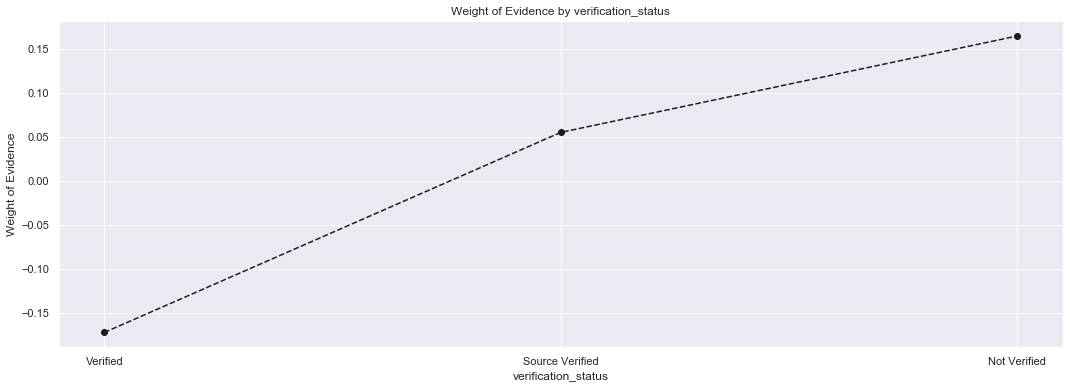

In [74]:
plot_by_woe(df_temp)


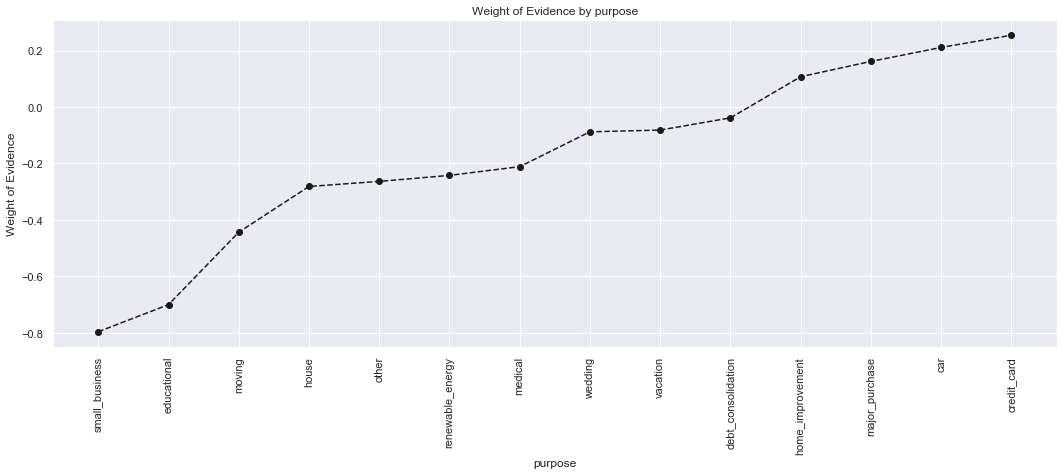

In [75]:
df_temp = woe_discrete(df_inputs_prepr, 'purpose', df_targets_prepr)
# We calculate weight of evidence.
plot_by_woe(df_temp, 90)


In [76]:
# We combine 'educational', 'small_business', 'wedding', 'renewable_energy', 'moving', 'house' in one category: 'educ__sm_b__wedd__ren_en__mov__house'.
# We combine 'other', 'medical', 'vacation' in one category: 'oth__med__vacation'.
# We combine 'major_purchase', 'car', 'home_improvement' in one category: 'major_purch__car__home_impr'.
# We leave 'debt_consolidtion' in a separate category.
# We leave 'credit_card' in a separate category.
# 'educ__sm_b__wedd__ren_en__mov__house' will be the reference category.
df_inputs_prepr['purpose:educ__sm_b__wedd__ren_en__mov__house'] = sum([df_inputs_prepr['purpose:educational'], df_inputs_prepr['purpose:small_business'],
                                                                 df_inputs_prepr['purpose:wedding'], df_inputs_prepr['purpose:renewable_energy'],
                                                                 df_inputs_prepr['purpose:moving'], df_inputs_prepr['purpose:house']])
df_inputs_prepr['purpose:oth__med__vacation'] = sum([df_inputs_prepr['purpose:other'], df_inputs_prepr['purpose:medical'],
                                             df_inputs_prepr['purpose:vacation']])
df_inputs_prepr['purpose:major_purch__car__home_impr'] = sum([df_inputs_prepr['purpose:major_purchase'], df_inputs_prepr['purpose:car'],
                                                        df_inputs_prepr['purpose:home_improvement']])

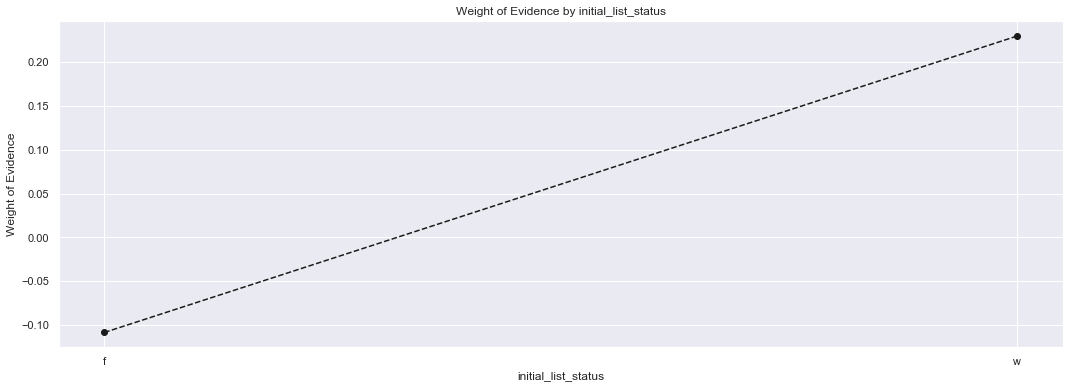

In [77]:
df_temp = woe_discrete(df_inputs_prepr, 'initial_list_status', df_targets_prepr)
plot_by_woe(df_temp)


In [78]:
# WoE function for ordered discrete and continuous variables
def woe_ordered_continuous(df, continuous_variabe_name, good_bad_variable_df):
    df = pd.concat([df[continuous_variabe_name], good_bad_variable_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df
# Here we define a function similar to the one above, ...
# ... with one slight difference: we order the results by the values of a different column.
# The function takes 3 arguments: a dataframe, a string, and a dataframe. The function returns a dataframe as a result.

In [79]:
df_inputs_prepr['term_int'].unique()
#only 2 variables so we have to keep in different categories 

array([36, 60])

In [80]:
df_inputs_prepr['term:36'] = np.where((df_inputs_prepr['term_int'] == 36), 1, 0)
df_inputs_prepr['term:60'] = np.where((df_inputs_prepr['term_int'] == 60), 1, 0)

In [81]:
df_inputs_prepr['emp_length_int'].unique()


array([ 3.,  6., 10.,  7.,  5.,  0.,  2.,  9.,  1.,  8.,  4.])

In [82]:
df_temp = woe_ordered_continuous(df_inputs_prepr, 'emp_length_int', df_targets_prepr)
# We calculate weight of evidence.
df_temp

,emp_length_int,n_obs,prop_good,prop_n_obs,n_good,n_bad,prop_n_good,prop_n_bad,WoE,diff_prop_good,diff_WoE,IV
0,0.0,45720,0.876400,0.122565,40069.0,5651.0,0.120599,0.138580,-0.138975,NaN,NaN,0.006506
1,1.0,23654,0.886996,0.063411,20981.0,2673.0,0.063148,0.065550,-0.037329,0.010596,0.101645,0.006506
2,2.0,33078,0.890955,0.088674,29471.0,3607.0,0.088701,0.088455,0.002785,0.003959,0.040114,0.006506
3,3.0,29205,0.890772,0.078292,26015.0,3190.0,0.078299,0.078228,0.000907,0.000183,0.001878,0.006506
4,4.0,22468,0.890644,0.060231,20011.0,2457.0,0.060229,0.060253,-0.000404,0.000128,0.001311,0.006506
5,5.0,24602,0.884725,0.065952,21766.0,2836.0,0.065511,0.069547,-0.059790,0.005920,0.059387,0.006506
6,6.0,20887,0.883899,0.055993,18462.0,2425.0,0.055567,0.059468,-0.067862,0.000826,0.008071,0.006506
7,7.0,21049,0.887453,0.056427,18680.0,2369.0,0.056223,0.058095,-0.032759,0.003554,0.035102,0.006506
8,8.0,17853,0.889878,0.047860,15887.0,1966.0,0.047816,0.048212,-0.008245,0.002425,0.024515,0.006506
9,9.0,14267,0.886662,0.038246,12650.0,1617.0,0.038074,0.039654,-0.040660,0.003217,0.032416,0.006506


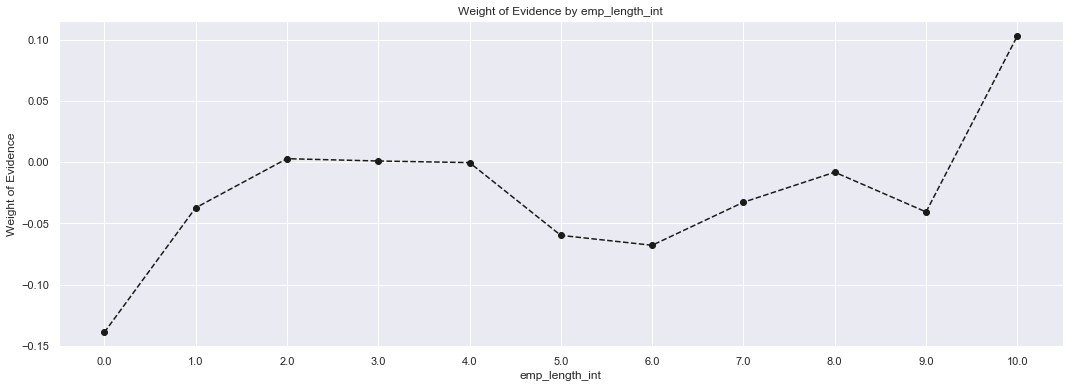

In [83]:
plot_by_woe(df_temp)


In [84]:
# We create the following categories: '0', '1', '2 - 4', '5 - 6', '7 - 9', '10'
# Can be clubbed into other categories, not necessarily these.
# '0' will be the reference category
df_inputs_prepr['emp_length:0'] = np.where(df_inputs_prepr['emp_length_int'].isin([0]), 1, 0)
df_inputs_prepr['emp_length:1'] = np.where(df_inputs_prepr['emp_length_int'].isin([1]), 1, 0)
df_inputs_prepr['emp_length:2-4'] = np.where(df_inputs_prepr['emp_length_int'].isin(range(2, 5)), 1, 0)
df_inputs_prepr['emp_length:5-6'] = np.where(df_inputs_prepr['emp_length_int'].isin(range(5, 7)), 1, 0)
df_inputs_prepr['emp_length:7-9'] = np.where(df_inputs_prepr['emp_length_int'].isin(range(7, 10)), 1, 0)
df_inputs_prepr['emp_length:10'] = np.where(df_inputs_prepr['emp_length_int'].isin([10]), 1, 0)